# Sentimen Analisis Model Indo

In [1]:
from gensim.models import Doc2Vec
import re
import os
import pandas as pd
import numpy as np
import multiprocessing
import ipython_genutils
import pickle
import progressbar
import tensorflow as tf
from gensim.models import KeyedVectors
from keras.preprocessing.sequence import pad_sequences
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, MaxPooling1D,GRU,LSTM
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.metrics import classification_report
from sklearn import model_selection
from sklearn import utils
from sklearn.utils import shuffle
from gensim.models.word2vec import Word2Vec
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

Using TensorFlow backend.


### load file csv

target
1. negative = -1
2. neutral = 0
3. positive = 1

In [2]:
df = pd.read_csv('lib/dataset',index_col=0)
df1 = pd.read_csv('lib/dataset ahok',index_col=0)
df2 = pd.read_csv('lib/datasetfm',index_col=0)
df=pd.concat([df,df1,df2],sort=False)
#df['target']=df['target'].map({0:-1,1:0,2:1})
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
df = shuffle(df)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18182 entries, 17653 to 10823
Data columns (total 2 columns):
text      18182 non-null object
target    18182 non-null int64
dtypes: int64(1), object(1)
memory usage: 426.1+ KB


,text,target
17653,ente paham cara ind,0
7459,jumat malam sama kawan dalam mobil tuju sebwah...,0
12445,kamu aja sampe ini ko ngga kabarnya,-1
3523,satu putar kalah ahok sangka ahok masuk bui,-1
16884,diam diamekarang mungkin kamu cinta diam mungk...,-1


### jumlah data tiap class

In [3]:
df.groupby('target')['text'].count()

target
-1    6041
 0    6146
 1    5995
Name: text, dtype: int64

### One Hot 

### downsampling dataset

In [4]:
dneg=df.query('target == -1')
dnet=df.query('target == 0')
dpos=df.query('target == 1')

minlen=min(len(dnet.index),len(dpos.index),len(dneg.index))


dnet=dnet.head(minlen)
dneg=dneg.head(minlen)
dpos=dpos.head(minlen)

data_training=pd.concat([dneg.text,dnet.text,dpos.text])
target=pd.concat([dneg.target,dnet.target,dpos.target])
target=to_categorical(target-target.min())

In [5]:
# tanpa downsampling
data_training=df.text
target=df.target
target=to_categorical(target-target.min())

In [6]:
df_ds=pd.DataFrame({'text':data_training,'target':np.argmax(target, axis=1, out=None)})
df_ds.groupby('target')['text'].count()

target
0    6041
1    6146
2    5995
Name: text, dtype: int64

### tokenizing

create tokenizer lalu di save ada/dibuat tokenizer. jika sudah dibuat maka skip langsung ke load tokenizer

In [7]:
#save tokenizer
#data=df.text
#tokenizer = Tokenizer(num_words=100000)
#tokenizer.fit_on_texts(data)                        
#sequences = tokenizer.texts_to_sequences(data) 
#with open('lib/tokenizer_indo.pickle', 'wb') as handle:
#    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

load tokenizer lalu konversi dataset jadi vector

In [8]:
print('tokenizing')
num_words=100000
tokenizer = Tokenizer(num_words)
with open('lib/tokenizer_indo.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
sequences = tokenizer.texts_to_sequences(data_training) 

tokenizing


In [9]:
sequences[0]

[1011, 712, 230, 3009]

### padding

In [10]:
print('padding')
input_seq = pad_sequences(sequences, maxlen=70)

padding


In [11]:
input_seq[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       1011,  712,  230, 3009])

### split dataset jadi data training dan data validasi

In [12]:
input_train, input_val, target_train, target_val = model_selection.train_test_split(input_seq,target,test_size = 0.2, random_state = 0)

print('data train\t: ',len(input_train))
print('data validasi\t: ',len(input_val),)

data train	:  14545
data validasi	:  3637


### Parameter

1. ep = epoch
2. bs = batch size
3. traina = True atau False 
4. lanjut = True atau False

ket.
1. jumlah epoch training model
2. jumlah batch size dlm training
3. True untuk trainable sehingga dalam proses training model word embedding juga di train. False untuk word embedding tidak ikut di train.
4. True untuk me-load model yg sudah di train sebelumnya/pretrained model lalu model tsb di train lagi. False untuk training model dari awal seperti model baru/ blm di train 

In [13]:
ep=135
bs=32
traina=True
lanjut=False

# Model

Model
1. Word2Vec
2. DBOW
3. DMM
4. DMC
5. DBOW-DMM
6. DBOW-DMC
7. DMM-DMC
8. DBOW-DMM-DMC

### neural network

In [14]:
def getModel(num_word,embed_dim,embed_weight,input_len,trainable):
    seed = 7
    model = Sequential()
    e = Embedding(num_word, embed_dim, weights=[embed_weight], input_length=input_len, trainable=trainable)
    model.add(e)
    model.add(Conv1D(32,kernel_size=2,padding='same',activation='relu'))
    model.add(MaxPooling1D())
    model.add(Dropout(0.3))
    model.add(Conv1D(64,kernel_size=2,padding='same',activation='relu'))
    model.add(MaxPooling1D())
    model.add(Dropout(0.35))
    model.add(Conv1D(128,kernel_size=2,padding='same',activation='relu'))
    model.add(MaxPooling1D())
    model.add(Dropout(0.4))
    model.add(LSTM(50,return_sequences=True))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.45))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
    model.summary()
    return model

In [15]:
def saveModel(model,path):
    model_json = model.to_json()
    with open(path, "w") as json_file:
        json_file.write(model_json)

In [16]:
def train(model,lanjut, path_weights,input_train,target_train,input_val,target_val,epoch,bs):
    if lanjut==True:
        model.load_weights(path_weights)
    filepath=path_weights
    checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history=model.fit(input_train, target_train,validation_data=(input_val, target_val), shuffle=False, epochs=ep, batch_size=bs,callbacks=callbacks_list)
    return history

In [17]:
def score(weights,input_val,target_val):
    model.load_weights(weights)
    scores = model.evaluate(input_val, target_val)
    print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    print()
    predict = model.predict_classes(input_val)
    y_true = np.argmax(target_val, axis=1, out=None)
    y_pred = predict
    target_names = ['negative', 'neutral', 'positive']
    print (classification_report(y_true, y_pred, target_names=target_names))

In [18]:
def plot(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# Train

## Word2Vec

In [19]:
# load word2vec
model_ug_cbow = KeyedVectors.load('lib/cbow_indo.word2vec')
model_ug_sg = KeyedVectors.load('lib/sg_indo.word2vec')
print('word2vec loaded')

# words embedding
embeddings_index = {}
for w in model_ug_cbow.wv.vocab.keys():
    embeddings_index[w] =np.append( model_ug_cbow.wv[w],model_ug_sg.wv[w])

num_words = 100000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('embed')

word2vec loaded
embed


In [20]:
model=getModel(num_words, 200, embedding_matrix, 70, traina)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 70, 200)           20000000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 70, 32)            12832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 35, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 64)            4160      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 17, 64)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 17, 64)            0         
__________

In [21]:
saveModel(model,"lib/model_w2v_indo.json")

In [22]:
history=train(model,lanjut, 'lib/weights_w2v.hdf5',input_train,target_train,input_val,target_val,ep,bs)

Train on 14545 samples, validate on 3637 samples
Epoch 1/135
14545/14545 [==============================] - 34s 2ms/step - loss: 1.0097 - categorical_accuracy: 0.4619 - val_loss: 0.9146 - val_categorical_accuracy: 0.5653

Epoch 00001: val_categorical_accuracy improved from -inf to 0.56530, saving model to lib/weights_w2v.hdf5
Epoch 2/135
14545/14545 [==============================] - 28s 2ms/step - loss: 0.8669 - categorical_accuracy: 0.5889 - val_loss: 0.8804 - val_categorical_accuracy: 0.5909

Epoch 00002: val_categorical_accuracy improved from 0.56530 to 0.59087, saving model to lib/weights_w2v.hdf5
Epoch 3/135
14545/14545 [==============================] - 28s 2ms/step - loss: 0.7562 - categorical_accuracy: 0.6617 - val_loss: 0.8298 - val_categorical_accuracy: 0.6464

Epoch 00003: val_categorical_accuracy improved from 0.59087 to 0.64641, saving model to lib/weights_w2v.hdf5
Epoch 4/135
14545/14545 [==============================] - 28s 2ms/step - loss: 0.6343 - categorical_accurac

14545/14545 [==============================] - 27s 2ms/step - loss: 0.1790 - categorical_accuracy: 0.9312 - val_loss: 1.8485 - val_categorical_accuracy: 0.6489

Epoch 00034: val_categorical_accuracy did not improve from 0.66896
Epoch 35/135
14545/14545 [==============================] - 27s 2ms/step - loss: 0.1836 - categorical_accuracy: 0.9283 - val_loss: 1.8055 - val_categorical_accuracy: 0.6464

Epoch 00035: val_categorical_accuracy did not improve from 0.66896
Epoch 36/135
14545/14545 [==============================] - 27s 2ms/step - loss: 0.1810 - categorical_accuracy: 0.9286 - val_loss: 1.9900 - val_categorical_accuracy: 0.6472

Epoch 00036: val_categorical_accuracy did not improve from 0.66896
Epoch 37/135
14545/14545 [==============================] - 27s 2ms/step - loss: 0.1796 - categorical_accuracy: 0.9316 - val_loss: 1.9316 - val_categorical_accuracy: 0.6500

Epoch 00037: val_categorical_accuracy did not improve from 0.66896
Epoch 38/135
14545/14545 [=======================

14545/14545 [==============================] - 27s 2ms/step - loss: 0.1497 - categorical_accuracy: 0.9401 - val_loss: 2.1904 - val_categorical_accuracy: 0.6395

Epoch 00067: val_categorical_accuracy did not improve from 0.66896
Epoch 68/135
14545/14545 [==============================] - 27s 2ms/step - loss: 0.1511 - categorical_accuracy: 0.9397 - val_loss: 2.1838 - val_categorical_accuracy: 0.6472

Epoch 00068: val_categorical_accuracy did not improve from 0.66896
Epoch 69/135
14545/14545 [==============================] - 27s 2ms/step - loss: 0.1405 - categorical_accuracy: 0.9448 - val_loss: 2.2790 - val_categorical_accuracy: 0.6483

Epoch 00069: val_categorical_accuracy did not improve from 0.66896
Epoch 70/135
14545/14545 [==============================] - 27s 2ms/step - loss: 0.1422 - categorical_accuracy: 0.9412 - val_loss: 2.2812 - val_categorical_accuracy: 0.6437

Epoch 00070: val_categorical_accuracy did not improve from 0.66896
Epoch 71/135
14545/14545 [=======================

14545/14545 [==============================] - 27s 2ms/step - loss: 0.1292 - categorical_accuracy: 0.9477 - val_loss: 2.2441 - val_categorical_accuracy: 0.6382

Epoch 00101: val_categorical_accuracy did not improve from 0.66896
Epoch 102/135
14545/14545 [==============================] - 28s 2ms/step - loss: 0.1296 - categorical_accuracy: 0.9494 - val_loss: 2.3581 - val_categorical_accuracy: 0.6382

Epoch 00102: val_categorical_accuracy did not improve from 0.66896
Epoch 103/135
14545/14545 [==============================] - 28s 2ms/step - loss: 0.1264 - categorical_accuracy: 0.9489 - val_loss: 2.4853 - val_categorical_accuracy: 0.6417

Epoch 00103: val_categorical_accuracy did not improve from 0.66896
Epoch 104/135
14545/14545 [==============================] - 27s 2ms/step - loss: 0.1265 - categorical_accuracy: 0.9492 - val_loss: 2.3989 - val_categorical_accuracy: 0.6406

Epoch 00104: val_categorical_accuracy did not improve from 0.66896
Epoch 105/135
14545/14545 [===================

14545/14545 [==============================] - 27s 2ms/step - loss: 0.1166 - categorical_accuracy: 0.9527 - val_loss: 2.4254 - val_categorical_accuracy: 0.6357

Epoch 00135: val_categorical_accuracy did not improve from 0.66896


In [23]:
score('lib/weights_w2v.hdf5',input_val,target_val)

3637/3637 [==============================] - 1s 267us/step

categorical_accuracy: 66.90%

              precision    recall  f1-score   support

    negative       0.70      0.63      0.67      1213
     neutral       0.61      0.72      0.66      1224
    positive       0.71      0.66      0.68      1200

   micro avg       0.67      0.67      0.67      3637
   macro avg       0.67      0.67      0.67      3637
weighted avg       0.67      0.67      0.67      3637



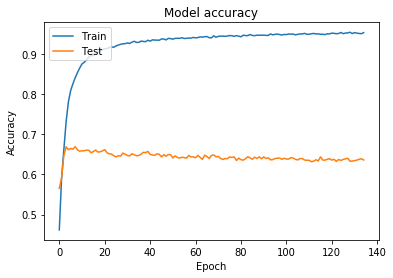

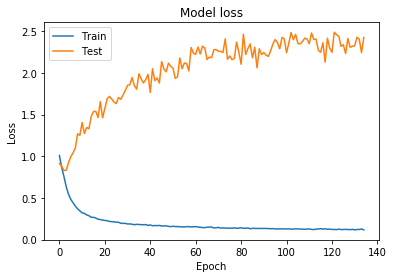

In [ ]:
plot(history)

## DBOW

In [ ]:
model_ug_cbow = Doc2Vec.load('lib/d2v_dbow_indo')

print('word2vec loaded')

# words embedding
embeddings_index = {}
for w in model_ug_cbow.wv.vocab.keys():
    embeddings_index[w] = model_ug_cbow.wv[w]

num_words = 100000
embedding_matrix = np.zeros((num_words, 100))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('embed')

word2vec loaded
embed


In [ ]:
model=getModel(num_words, 100, embedding_matrix, 70, traina)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 70, 100)           10000000  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 70, 32)            6432      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 35, 32)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 35, 32)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 35, 64)            4160      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 17, 64)            0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 17, 64)            0         
__________

In [ ]:
saveModel(model,"lib/model_dbow_indo.json")

In [ ]:
history=train(model,lanjut, 'lib/weights_dbow.hdf5',input_train,target_train,input_val,target_val,ep,bs)

Train on 14545 samples, validate on 3637 samples
Epoch 1/135
14545/14545 [==============================] - 26s 2ms/step - loss: 0.9623 - categorical_accuracy: 0.5069 - val_loss: 0.8613 - val_categorical_accuracy: 0.5969

Epoch 00001: val_categorical_accuracy improved from -inf to 0.59692, saving model to lib/weights_dbow.hdf5
Epoch 2/135
14545/14545 [==============================] - 19s 1ms/step - loss: 0.7761 - categorical_accuracy: 0.6518 - val_loss: 0.8013 - val_categorical_accuracy: 0.6335

Epoch 00002: val_categorical_accuracy improved from 0.59692 to 0.63349, saving model to lib/weights_dbow.hdf5
Epoch 3/135
14545/14545 [==============================] - 19s 1ms/step - loss: 0.6383 - categorical_accuracy: 0.7361 - val_loss: 0.8153 - val_categorical_accuracy: 0.6640

Epoch 00003: val_categorical_accuracy improved from 0.63349 to 0.66401, saving model to lib/weights_dbow.hdf5
Epoch 4/135
14545/14545 [==============================] - 19s 1ms/step - loss: 0.5425 - categorical_accu

14545/14545 [==============================] - 20s 1ms/step - loss: 0.1423 - categorical_accuracy: 0.9469 - val_loss: 1.7047 - val_categorical_accuracy: 0.6461

Epoch 00034: val_categorical_accuracy did not improve from 0.66923
Epoch 35/135
14545/14545 [==============================] - 19s 1ms/step - loss: 0.1402 - categorical_accuracy: 0.9469 - val_loss: 1.7665 - val_categorical_accuracy: 0.6470

Epoch 00035: val_categorical_accuracy did not improve from 0.66923
Epoch 36/135
14545/14545 [==============================] - 19s 1ms/step - loss: 0.1443 - categorical_accuracy: 0.9475 - val_loss: 1.8282 - val_categorical_accuracy: 0.6472

Epoch 00036: val_categorical_accuracy did not improve from 0.66923
Epoch 37/135
14545/14545 [==============================] - 19s 1ms/step - loss: 0.1374 - categorical_accuracy: 0.9482 - val_loss: 1.7812 - val_categorical_accuracy: 0.6461

Epoch 00037: val_categorical_accuracy did not improve from 0.66923
Epoch 38/135
14545/14545 [=======================

14545/14545 [==============================] - 19s 1ms/step - loss: 0.1141 - categorical_accuracy: 0.9584 - val_loss: 2.1927 - val_categorical_accuracy: 0.6445

Epoch 00068: val_categorical_accuracy did not improve from 0.66923
Epoch 69/135
14545/14545 [==============================] - 19s 1ms/step - loss: 0.1157 - categorical_accuracy: 0.9548 - val_loss: 2.1682 - val_categorical_accuracy: 0.6329

Epoch 00069: val_categorical_accuracy did not improve from 0.66923
Epoch 70/135
14545/14545 [==============================] - 19s 1ms/step - loss: 0.1063 - categorical_accuracy: 0.9573 - val_loss: 2.2259 - val_categorical_accuracy: 0.6434

Epoch 00070: val_categorical_accuracy did not improve from 0.66923
Epoch 71/135
14545/14545 [==============================] - 19s 1ms/step - loss: 0.1128 - categorical_accuracy: 0.9565 - val_loss: 2.2513 - val_categorical_accuracy: 0.6426

Epoch 00071: val_categorical_accuracy did not improve from 0.66923
Epoch 72/135
14545/14545 [=======================

14545/14545 [==============================] - 20s 1ms/step - loss: 0.1002 - categorical_accuracy: 0.9594 - val_loss: 2.5867 - val_categorical_accuracy: 0.6431

Epoch 00102: val_categorical_accuracy did not improve from 0.66923
Epoch 103/135
14545/14545 [==============================] - 19s 1ms/step - loss: 0.0992 - categorical_accuracy: 0.9612 - val_loss: 2.3146 - val_categorical_accuracy: 0.6461

Epoch 00103: val_categorical_accuracy did not improve from 0.66923
Epoch 104/135
14545/14545 [==============================] - 19s 1ms/step - loss: 0.0992 - categorical_accuracy: 0.9594 - val_loss: 2.4072 - val_categorical_accuracy: 0.6423

Epoch 00104: val_categorical_accuracy did not improve from 0.66923
Epoch 105/135
14545/14545 [==============================] - 20s 1ms/step - loss: 0.1006 - categorical_accuracy: 0.9594 - val_loss: 2.3193 - val_categorical_accuracy: 0.6489

Epoch 00105: val_categorical_accuracy did not improve from 0.66923
Epoch 106/135
14545/14545 [===================

In [ ]:
score('lib/weights_dbow.hdf5',input_val,target_val)

3637/3637 [==============================] - 1s 267us/step

categorical_accuracy: 66.92%

              precision    recall  f1-score   support

    negative       0.66      0.69      0.68      1213
     neutral       0.64      0.66      0.65      1224
    positive       0.70      0.65      0.68      1200

   micro avg       0.67      0.67      0.67      3637
   macro avg       0.67      0.67      0.67      3637
weighted avg       0.67      0.67      0.67      3637



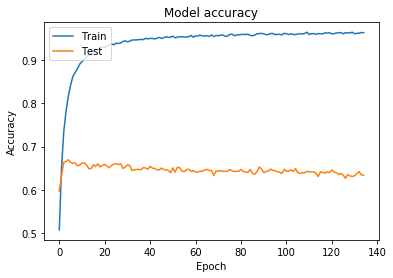

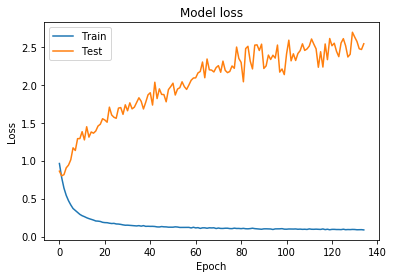

In [ ]:
plot(history)

## DMM

In [ ]:
model_ug_cbow = Doc2Vec.load('lib/d2v_dmm_indo')

print('word2vec loaded')

# words embedding
embeddings_index = {}
for w in model_ug_cbow.wv.vocab.keys():
    embeddings_index[w] = model_ug_cbow.wv[w]

num_words = 100000
embedding_matrix = np.zeros((num_words, 100))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('embed')


word2vec loaded
embed


In [ ]:
model=getModel(num_words, 100, embedding_matrix, 70, traina)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 70, 100)           10000000  
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 70, 32)            6432      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 35, 32)            0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 35, 32)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 35, 64)            4160      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 17, 64)            0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 17, 64)            0         
__________

In [ ]:
saveModel(model,"lib/model_dmm_indo.json")

In [ ]:
history=train(model,lanjut, 'lib/weights_dmm.hdf5',input_train,target_train,input_val,target_val,ep,bs)

Train on 14545 samples, validate on 3637 samples
Epoch 1/135
14545/14545 [==============================] - 24s 2ms/step - loss: 1.0192 - categorical_accuracy: 0.4641 - val_loss: 0.8783 - val_categorical_accuracy: 0.5922

Epoch 00001: val_categorical_accuracy improved from -inf to 0.59225, saving model to lib/weights_dmm.hdf5
Epoch 2/135
14545/14545 [==============================] - 19s 1ms/step - loss: 0.8600 - categorical_accuracy: 0.6030 - val_loss: 0.7918 - val_categorical_accuracy: 0.6398

Epoch 00002: val_categorical_accuracy improved from 0.59225 to 0.63981, saving model to lib/weights_dmm.hdf5
Epoch 3/135
14545/14545 [==============================] - 19s 1ms/step - loss: 0.7784 - categorical_accuracy: 0.6566 - val_loss: 0.7530 - val_categorical_accuracy: 0.6613

Epoch 00003: val_categorical_accuracy improved from 0.63981 to 0.66126, saving model to lib/weights_dmm.hdf5
Epoch 4/135
14545/14545 [==============================] - 19s 1ms/step - loss: 0.7315 - categorical_accurac

14545/14545 [==============================] - 20s 1ms/step - loss: 0.2691 - categorical_accuracy: 0.8985 - val_loss: 1.2940 - val_categorical_accuracy: 0.6662

Epoch 00033: val_categorical_accuracy did not improve from 0.69205
Epoch 34/135
14545/14545 [==============================] - 19s 1ms/step - loss: 0.2624 - categorical_accuracy: 0.9011 - val_loss: 1.3283 - val_categorical_accuracy: 0.6695

Epoch 00034: val_categorical_accuracy did not improve from 0.69205
Epoch 35/135
14545/14545 [==============================] - 20s 1ms/step - loss: 0.2577 - categorical_accuracy: 0.9007 - val_loss: 1.3783 - val_categorical_accuracy: 0.6687

Epoch 00035: val_categorical_accuracy did not improve from 0.69205
Epoch 36/135
14545/14545 [==============================] - 20s 1ms/step - loss: 0.2489 - categorical_accuracy: 0.9052 - val_loss: 1.3384 - val_categorical_accuracy: 0.6712

Epoch 00036: val_categorical_accuracy did not improve from 0.69205
Epoch 37/135
14545/14545 [=======================

14545/14545 [==============================] - 20s 1ms/step - loss: 0.1801 - categorical_accuracy: 0.9321 - val_loss: 1.6166 - val_categorical_accuracy: 0.6536

Epoch 00067: val_categorical_accuracy did not improve from 0.69205
Epoch 68/135
14545/14545 [==============================] - 20s 1ms/step - loss: 0.1796 - categorical_accuracy: 0.9301 - val_loss: 1.7078 - val_categorical_accuracy: 0.6593

Epoch 00068: val_categorical_accuracy did not improve from 0.69205
Epoch 69/135
14545/14545 [==============================] - 20s 1ms/step - loss: 0.1708 - categorical_accuracy: 0.9346 - val_loss: 1.7875 - val_categorical_accuracy: 0.6571

Epoch 00069: val_categorical_accuracy did not improve from 0.69205
Epoch 70/135
14545/14545 [==============================] - 20s 1ms/step - loss: 0.1728 - categorical_accuracy: 0.9354 - val_loss: 1.7498 - val_categorical_accuracy: 0.6610

Epoch 00070: val_categorical_accuracy did not improve from 0.69205
Epoch 71/135
14545/14545 [=======================

14545/14545 [==============================] - 19s 1ms/step - loss: 0.1468 - categorical_accuracy: 0.9431 - val_loss: 1.9118 - val_categorical_accuracy: 0.6472

Epoch 00101: val_categorical_accuracy did not improve from 0.69205
Epoch 102/135
14545/14545 [==============================] - 19s 1ms/step - loss: 0.1510 - categorical_accuracy: 0.9422 - val_loss: 1.8586 - val_categorical_accuracy: 0.6516

Epoch 00102: val_categorical_accuracy did not improve from 0.69205
Epoch 103/135
14545/14545 [==============================] - 19s 1ms/step - loss: 0.1463 - categorical_accuracy: 0.9431 - val_loss: 2.0014 - val_categorical_accuracy: 0.6461

Epoch 00103: val_categorical_accuracy did not improve from 0.69205
Epoch 104/135
14545/14545 [==============================] - 19s 1ms/step - loss: 0.1444 - categorical_accuracy: 0.9455 - val_loss: 2.0647 - val_categorical_accuracy: 0.6503

Epoch 00104: val_categorical_accuracy did not improve from 0.69205
Epoch 105/135
14545/14545 [===================


Epoch 00134: val_categorical_accuracy did not improve from 0.69205
Epoch 135/135
14545/14545 [==============================] - 19s 1ms/step - loss: 0.1346 - categorical_accuracy: 0.9488 - val_loss: 1.8919 - val_categorical_accuracy: 0.6494

Epoch 00135: val_categorical_accuracy did not improve from 0.69205


In [ ]:
score('lib/weights_dmm.hdf5',input_val,target_val)

3637/3637 [==============================] - 1s 263us/step

categorical_accuracy: 69.21%

              precision    recall  f1-score   support

    negative       0.71      0.70      0.70      1213
     neutral       0.63      0.72      0.67      1224
    positive       0.75      0.66      0.70      1200

   micro avg       0.69      0.69      0.69      3637
   macro avg       0.70      0.69      0.69      3637
weighted avg       0.70      0.69      0.69      3637



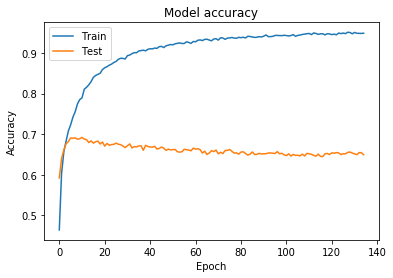

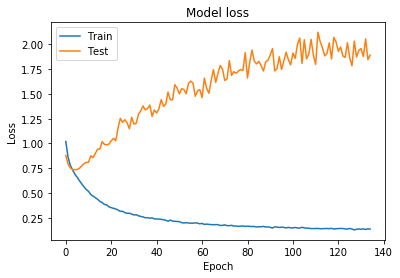

In [ ]:
plot(history)

## DMC

In [ ]:
model_ug_cbow = Doc2Vec.load('lib/d2v_dmc_indo')

print('word2vec loaded')

# words embedding
embeddings_index = {}
for w in model_ug_cbow.wv.vocab.keys():
    #embeddings_index[w] =np.append( model_ug_cbow.wv[w],model_ug_sg.wv[w])
    embeddings_index[w] = model_ug_cbow.wv[w]

num_words = 100000
embedding_matrix = np.zeros((num_words, 100))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('embed')

word2vec loaded
embed


In [ ]:
model=getModel(num_words, 100, embedding_matrix, 70, traina)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 70, 100)           10000000  
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 70, 32)            6432      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 35, 32)            0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 35, 32)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 35, 64)            4160      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 17, 64)            0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 17, 64)            0         
__________

In [ ]:
saveModel(model,"lib/model_dmc_indo.json")

In [ ]:
history=train(model,lanjut, 'lib/weights_dmc.hdf5',input_train,target_train,input_val,target_val,ep,bs)

Train on 14545 samples, validate on 3637 samples
Epoch 1/135
14545/14545 [==============================] - 26s 2ms/step - loss: 0.9884 - categorical_accuracy: 0.4937 - val_loss: 0.8322 - val_categorical_accuracy: 0.6277

Epoch 00001: val_categorical_accuracy improved from -inf to 0.62772, saving model to lib/weights_dmc.hdf5
Epoch 2/135
14545/14545 [==============================] - 19s 1ms/step - loss: 0.8097 - categorical_accuracy: 0.6383 - val_loss: 0.7679 - val_categorical_accuracy: 0.6525

Epoch 00002: val_categorical_accuracy improved from 0.62772 to 0.65246, saving model to lib/weights_dmc.hdf5
Epoch 3/135
14545/14545 [==============================] - 19s 1ms/step - loss: 0.7281 - categorical_accuracy: 0.6848 - val_loss: 0.7360 - val_categorical_accuracy: 0.6805

Epoch 00003: val_categorical_accuracy improved from 0.65246 to 0.68051, saving model to lib/weights_dmc.hdf5
Epoch 4/135
14545/14545 [==============================] - 19s 1ms/step - loss: 0.6598 - categorical_accurac

14545/14545 [==============================] - 19s 1ms/step - loss: 0.2022 - categorical_accuracy: 0.9233 - val_loss: 1.4391 - val_categorical_accuracy: 0.6772

Epoch 00034: val_categorical_accuracy did not improve from 0.69123
Epoch 35/135
14545/14545 [==============================] - 19s 1ms/step - loss: 0.2014 - categorical_accuracy: 0.9229 - val_loss: 1.4779 - val_categorical_accuracy: 0.6734

Epoch 00035: val_categorical_accuracy did not improve from 0.69123
Epoch 36/135
14545/14545 [==============================] - 19s 1ms/step - loss: 0.1997 - categorical_accuracy: 0.9226 - val_loss: 1.5736 - val_categorical_accuracy: 0.6723

Epoch 00036: val_categorical_accuracy did not improve from 0.69123
Epoch 37/135
14545/14545 [==============================] - 19s 1ms/step - loss: 0.1986 - categorical_accuracy: 0.9243 - val_loss: 1.5190 - val_categorical_accuracy: 0.6676

Epoch 00037: val_categorical_accuracy did not improve from 0.69123
Epoch 38/135
14545/14545 [=======================

14545/14545 [==============================] - 19s 1ms/step - loss: 0.1499 - categorical_accuracy: 0.9413 - val_loss: 1.9935 - val_categorical_accuracy: 0.6599

Epoch 00068: val_categorical_accuracy did not improve from 0.69123
Epoch 69/135
14545/14545 [==============================] - 19s 1ms/step - loss: 0.1522 - categorical_accuracy: 0.9405 - val_loss: 1.9866 - val_categorical_accuracy: 0.6500

Epoch 00069: val_categorical_accuracy did not improve from 0.69123
Epoch 70/135
14545/14545 [==============================] - 19s 1ms/step - loss: 0.1471 - categorical_accuracy: 0.9436 - val_loss: 1.8536 - val_categorical_accuracy: 0.6571

Epoch 00070: val_categorical_accuracy did not improve from 0.69123
Epoch 71/135
14545/14545 [==============================] - 19s 1ms/step - loss: 0.1422 - categorical_accuracy: 0.9427 - val_loss: 2.0600 - val_categorical_accuracy: 0.6585

Epoch 00071: val_categorical_accuracy did not improve from 0.69123
Epoch 72/135
14545/14545 [=======================

14545/14545 [==============================] - 19s 1ms/step - loss: 0.1329 - categorical_accuracy: 0.9454 - val_loss: 2.0380 - val_categorical_accuracy: 0.6530

Epoch 00102: val_categorical_accuracy did not improve from 0.69123
Epoch 103/135
14545/14545 [==============================] - 19s 1ms/step - loss: 0.1324 - categorical_accuracy: 0.9471 - val_loss: 2.3022 - val_categorical_accuracy: 0.6533

Epoch 00103: val_categorical_accuracy did not improve from 0.69123
Epoch 104/135
14545/14545 [==============================] - 19s 1ms/step - loss: 0.1265 - categorical_accuracy: 0.9495 - val_loss: 2.2706 - val_categorical_accuracy: 0.6494

Epoch 00104: val_categorical_accuracy did not improve from 0.69123
Epoch 105/135
14545/14545 [==============================] - 19s 1ms/step - loss: 0.1269 - categorical_accuracy: 0.9486 - val_loss: 2.3077 - val_categorical_accuracy: 0.6500

Epoch 00105: val_categorical_accuracy did not improve from 0.69123
Epoch 106/135
14545/14545 [===================

In [ ]:
score('lib/weights_dmc.hdf5',input_val,target_val)

3637/3637 [==============================] - 1s 256us/step

categorical_accuracy: 69.12%

              precision    recall  f1-score   support

    negative       0.71      0.68      0.70      1213
     neutral       0.65      0.72      0.68      1224
    positive       0.72      0.67      0.70      1200

   micro avg       0.69      0.69      0.69      3637
   macro avg       0.69      0.69      0.69      3637
weighted avg       0.69      0.69      0.69      3637



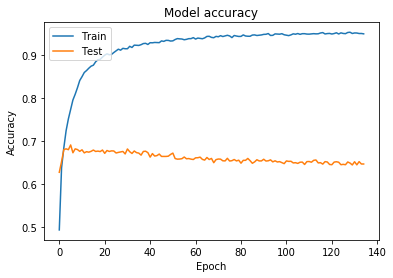

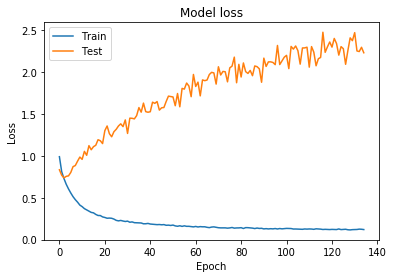

In [ ]:
plot(history)

## DBOW - DMM

In [ ]:
model_ug_cbow = Doc2Vec.load('lib/d2v_dbow_indo')
model_ug_sg = Doc2Vec.load('lib/d2v_dmm_indo')

print('word2vec loaded')

# words embedding
embeddings_index = {}
for w in model_ug_cbow.wv.vocab.keys():
    embeddings_index[w] =np.append( model_ug_cbow.wv[w],model_ug_sg.wv[w])
    #embeddings_index[w] = model_ug_cbow.wv[w]

num_words = 100000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('embed')

word2vec loaded
embed


In [ ]:
model=getModel(num_words, 200, embedding_matrix, 70, traina)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 70, 200)           20000000  
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 70, 32)            12832     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 35, 32)            0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 35, 32)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 35, 64)            4160      
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 17, 64)            0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 17, 64)            0         
__________

In [ ]:
saveModel(model,"lib/model_dbow-dmm_indo.json")

In [ ]:
history=train(model,lanjut, 'lib/weights_dbow-dmm.hdf5',input_train,target_train,input_val,target_val,ep,bs)

Train on 14545 samples, validate on 3637 samples
Epoch 1/135
14545/14545 [==============================] - 31s 2ms/step - loss: 0.9666 - categorical_accuracy: 0.5086 - val_loss: 0.8111 - val_categorical_accuracy: 0.6310

Epoch 00001: val_categorical_accuracy improved from -inf to 0.63101, saving model to lib/weights_dbow-dmm.hdf5
Epoch 2/135
14545/14545 [==============================] - 27s 2ms/step - loss: 0.7683 - categorical_accuracy: 0.6668 - val_loss: 0.7370 - val_categorical_accuracy: 0.6723

Epoch 00002: val_categorical_accuracy improved from 0.63101 to 0.67226, saving model to lib/weights_dbow-dmm.hdf5
Epoch 3/135
14545/14545 [==============================] - 27s 2ms/step - loss: 0.6610 - categorical_accuracy: 0.7221 - val_loss: 0.7540 - val_categorical_accuracy: 0.6813

Epoch 00003: val_categorical_accuracy improved from 0.67226 to 0.68133, saving model to lib/weights_dbow-dmm.hdf5
Epoch 4/135
14545/14545 [==============================] - 27s 2ms/step - loss: 0.5999 - cate

14545/14545 [==============================] - 27s 2ms/step - loss: 0.1887 - categorical_accuracy: 0.9298 - val_loss: 1.7593 - val_categorical_accuracy: 0.6544

Epoch 00034: val_categorical_accuracy did not improve from 0.68820
Epoch 35/135
14545/14545 [==============================] - 27s 2ms/step - loss: 0.1823 - categorical_accuracy: 0.9319 - val_loss: 1.6933 - val_categorical_accuracy: 0.6525

Epoch 00035: val_categorical_accuracy did not improve from 0.68820
Epoch 36/135
14545/14545 [==============================] - 27s 2ms/step - loss: 0.1807 - categorical_accuracy: 0.9323 - val_loss: 1.6877 - val_categorical_accuracy: 0.6582

Epoch 00036: val_categorical_accuracy did not improve from 0.68820
Epoch 37/135
14545/14545 [==============================] - 27s 2ms/step - loss: 0.1803 - categorical_accuracy: 0.9349 - val_loss: 1.6878 - val_categorical_accuracy: 0.6508

Epoch 00037: val_categorical_accuracy did not improve from 0.68820
Epoch 38/135
14545/14545 [=======================

14545/14545 [==============================] - 27s 2ms/step - loss: 0.1397 - categorical_accuracy: 0.9468 - val_loss: 2.0789 - val_categorical_accuracy: 0.6431

Epoch 00068: val_categorical_accuracy did not improve from 0.68820
Epoch 69/135
14545/14545 [==============================] - 27s 2ms/step - loss: 0.1350 - categorical_accuracy: 0.9499 - val_loss: 2.0818 - val_categorical_accuracy: 0.6470

Epoch 00069: val_categorical_accuracy did not improve from 0.68820
Epoch 70/135
14545/14545 [==============================] - 27s 2ms/step - loss: 0.1375 - categorical_accuracy: 0.9484 - val_loss: 1.9946 - val_categorical_accuracy: 0.6470

Epoch 00070: val_categorical_accuracy did not improve from 0.68820
Epoch 71/135
14545/14545 [==============================] - 27s 2ms/step - loss: 0.1345 - categorical_accuracy: 0.9488 - val_loss: 2.1473 - val_categorical_accuracy: 0.6401

Epoch 00071: val_categorical_accuracy did not improve from 0.68820
Epoch 72/135
14545/14545 [=======================

14545/14545 [==============================] - 27s 2ms/step - loss: 0.1243 - categorical_accuracy: 0.9550 - val_loss: 2.1113 - val_categorical_accuracy: 0.6439

Epoch 00102: val_categorical_accuracy did not improve from 0.68820
Epoch 103/135
14545/14545 [==============================] - 27s 2ms/step - loss: 0.1154 - categorical_accuracy: 0.9563 - val_loss: 2.1134 - val_categorical_accuracy: 0.6365

Epoch 00103: val_categorical_accuracy did not improve from 0.68820
Epoch 104/135
14545/14545 [==============================] - 27s 2ms/step - loss: 0.1204 - categorical_accuracy: 0.9543 - val_loss: 2.0855 - val_categorical_accuracy: 0.6329

Epoch 00104: val_categorical_accuracy did not improve from 0.68820
Epoch 105/135
14545/14545 [==============================] - 27s 2ms/step - loss: 0.1211 - categorical_accuracy: 0.9551 - val_loss: 2.1657 - val_categorical_accuracy: 0.6376

Epoch 00105: val_categorical_accuracy did not improve from 0.68820
Epoch 106/135
14545/14545 [===================

In [ ]:
score('lib/weights_dbow-dmm.hdf5',input_val,target_val)

3637/3637 [==============================] - 1s 261us/step

categorical_accuracy: 68.82%

              precision    recall  f1-score   support

    negative       0.70      0.69      0.70      1213
     neutral       0.66      0.68      0.67      1224
    positive       0.71      0.69      0.70      1200

   micro avg       0.69      0.69      0.69      3637
   macro avg       0.69      0.69      0.69      3637
weighted avg       0.69      0.69      0.69      3637



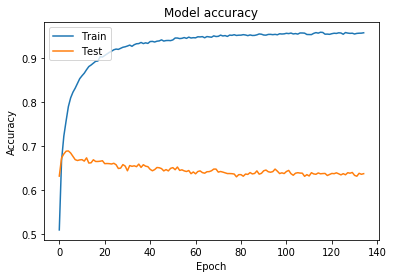

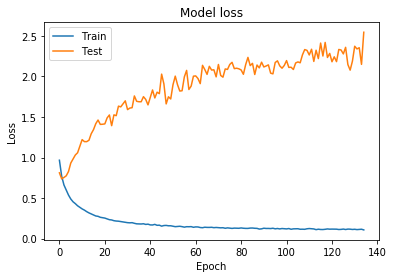

In [ ]:
plot(history)

## DBOW - DMC

In [ ]:
model_ug_cbow = Doc2Vec.load('lib/d2v_dbow_indo')
model_ug_sg = Doc2Vec.load('lib/d2v_dmc_indo')

print('word2vec loaded')

# words embedding
embeddings_index = {}
for w in model_ug_cbow.wv.vocab.keys():
    embeddings_index[w] =np.append( model_ug_cbow.wv[w],model_ug_sg.wv[w])
    #embeddings_index[w] = model_ug_cbow.wv[w]

num_words = 100000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('embed')

word2vec loaded
embed


In [ ]:
model=getModel(num_words, 200, embedding_matrix, 70, traina)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 70, 200)           20000000  
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 70, 32)            12832     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 35, 32)            0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 35, 32)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 35, 64)            4160      
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 17, 64)            0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 17, 64)            0         
__________

In [ ]:
saveModel(model,"lib/model_dbow-dmc_indo.json")

In [ ]:
history=train(model,lanjut, 'lib/weights_dbow-dmc.hdf5',input_train,target_train,input_val,target_val,ep,bs)

Train on 14545 samples, validate on 3637 samples
Epoch 1/135
14545/14545 [==============================] - 31s 2ms/step - loss: 0.9767 - categorical_accuracy: 0.5015 - val_loss: 0.8353 - val_categorical_accuracy: 0.6233

Epoch 00001: val_categorical_accuracy improved from -inf to 0.62332, saving model to lib/weights_dbow-dmc.hdf5
Epoch 2/135
14545/14545 [==============================] - 27s 2ms/step - loss: 0.7586 - categorical_accuracy: 0.6701 - val_loss: 0.7448 - val_categorical_accuracy: 0.6789

Epoch 00002: val_categorical_accuracy improved from 0.62332 to 0.67886, saving model to lib/weights_dbow-dmc.hdf5
Epoch 3/135
14545/14545 [==============================] - 27s 2ms/step - loss: 0.6387 - categorical_accuracy: 0.7388 - val_loss: 0.7727 - val_categorical_accuracy: 0.6802

Epoch 00003: val_categorical_accuracy improved from 0.67886 to 0.68023, saving model to lib/weights_dbow-dmc.hdf5
Epoch 4/135
14545/14545 [==============================] - 27s 2ms/step - loss: 0.5530 - cate

14545/14545 [==============================] - 27s 2ms/step - loss: 0.1758 - categorical_accuracy: 0.9335 - val_loss: 1.7393 - val_categorical_accuracy: 0.6558

Epoch 00034: val_categorical_accuracy did not improve from 0.68023
Epoch 35/135
14545/14545 [==============================] - 27s 2ms/step - loss: 0.1727 - categorical_accuracy: 0.9343 - val_loss: 1.8080 - val_categorical_accuracy: 0.6560

Epoch 00035: val_categorical_accuracy did not improve from 0.68023
Epoch 36/135
14545/14545 [==============================] - 27s 2ms/step - loss: 0.1700 - categorical_accuracy: 0.9347 - val_loss: 1.9943 - val_categorical_accuracy: 0.6593

Epoch 00036: val_categorical_accuracy did not improve from 0.68023
Epoch 37/135
14545/14545 [==============================] - 27s 2ms/step - loss: 0.1687 - categorical_accuracy: 0.9354 - val_loss: 1.8962 - val_categorical_accuracy: 0.6516

Epoch 00037: val_categorical_accuracy did not improve from 0.68023
Epoch 38/135
14545/14545 [=======================

14545/14545 [==============================] - 27s 2ms/step - loss: 0.1403 - categorical_accuracy: 0.9446 - val_loss: 2.0608 - val_categorical_accuracy: 0.6439

Epoch 00068: val_categorical_accuracy did not improve from 0.68023
Epoch 69/135
14545/14545 [==============================] - 27s 2ms/step - loss: 0.1335 - categorical_accuracy: 0.9475 - val_loss: 2.3387 - val_categorical_accuracy: 0.6467

Epoch 00069: val_categorical_accuracy did not improve from 0.68023
Epoch 70/135
14545/14545 [==============================] - 27s 2ms/step - loss: 0.1377 - categorical_accuracy: 0.9456 - val_loss: 2.1197 - val_categorical_accuracy: 0.6420

Epoch 00070: val_categorical_accuracy did not improve from 0.68023
Epoch 71/135
14545/14545 [==============================] - 27s 2ms/step - loss: 0.1332 - categorical_accuracy: 0.9480 - val_loss: 2.2965 - val_categorical_accuracy: 0.6390

Epoch 00071: val_categorical_accuracy did not improve from 0.68023
Epoch 72/135
14545/14545 [=======================

In [ ]:
score('lib/weights_dbow-dmc.hdf5',input_val,target_val)

In [ ]:
plot(history)

## DMM - DMC

In [ ]:
model_ug_cbow = Doc2Vec.load('lib/d2v_dmm_indo')
model_ug_sg = Doc2Vec.load('lib/d2v_dmc_indo')

print('word2vec loaded')

# words embedding
embeddings_index = {}
for w in model_ug_cbow.wv.vocab.keys():
    embeddings_index[w] =np.append( model_ug_cbow.wv[w],model_ug_sg.wv[w])
    #embeddings_index[w] = model_ug_cbow.wv[w]

num_words = 100000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('embed')

In [ ]:
model=getModel(num_words, 200, embedding_matrix, 70, traina)

In [ ]:
saveModel(model,"lib/model_dmm-dmc_indo.json")

In [ ]:
history=train(model,lanjut, 'lib/weights_dmm-dmc.hdf5',input_train,target_train,input_val,target_val,ep,bs)

In [ ]:
score('lib/weights_dmm-dmc.hdf5',input_val,target_val)

In [ ]:
plot(history)

## DBOW - DMM - DMC

In [ ]:
model_ug_cbow = Doc2Vec.load('lib/d2v_dbow_indo')
model_ug_sg = Doc2Vec.load('lib/d2v_dmm_indo')
model_ug_sg1 = Doc2Vec.load('lib/d2v_dmc_indo')

print('word2vec loaded')

# words embedding
embeddings_index = {}
for w in model_ug_cbow.wv.vocab.keys():
    embeddings_index[w] =np.append((np.append(model_ug_cbow.wv[w],model_ug_sg.wv[w])),model_ug_sg1.wv[w])
    

num_words = 100000
embedding_matrix = np.zeros((num_words, 300))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('embed')

In [ ]:
model=getModel(num_words, 300, embedding_matrix, 70, traina)

In [ ]:
saveModel(model,"lib/model_dbow-dmm-dmc_indo.json")

In [ ]:
history=train(model,lanjut, 'lib/weights_dbow-dmm-dmc.hdf5',input_train,target_train,input_val,target_val,ep,bs)

In [ ]:
score('lib/weights_dbow-dmm-dmc.hdf5',input_val,target_val)

In [ ]:
plot(history)